<a href="https://colab.research.google.com/github/ailiskab-hub/Prot_BERT_for_prediction_protein_localization/blob/main/Prot_BERT_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import datetime
import random
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import requests

query_url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28%28reviewed%3Atrue%29+AND+%28length%3A%5B200+TO+500%5D%29+AND+%28taxonomy_id%3A40674%29%29'

In [ ]:
uniprot_request = requests.get(query_url)
from io import BytesIO


bio = BytesIO(uniprot_request.content)

df = pd.read_csv(bio, compression='gzip', sep='\t')


In [ ]:
#df = pd.read_csv('protein_seq')
df

,Entry,Subcellular location [CC],Sequence
0,A0A061I403,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...
1,A0A096MJN4,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...,MIKHFLEDNSDDAELSKFVKDFPGSEPCHPTESKTRVARPQILEPR...
2,A0A096MJY4,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...
3,A0A0B4J1F4,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
4,A0A0B4J1G0,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,MWQLLLPTALVLTAFSGIQAGLQKAVVNLDPKWVRVLEEDSVTLRC...
...,...,...,...
30931,Q9H7T3,NaN,MERSNAATKCGEEPRSGSRRLPKAEGDKSGSAGAPSKNSSRLGGRP...
30932,Q9JJR6,NaN,MQPSASPGLPLPKYCSVATTVKAPDLHGAVPPWDMSFTCPFATQAP...
30933,Q9JJR9,NaN,MFYSGLLTEGGRKETDMREAASLRQQRRMKQAVQFIHKDSADLLPL...
30934,Q9Z1R4,NaN,MFLRRLGGWLPRPWGRKKSTKADLPAPEPRWVDSSPENSGSDWDSA...


In [ ]:
#df.to_csv('protein_seq', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30936 entries, 0 to 30935
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Entry                      30936 non-null  object
 1   Subcellular location [CC]  27489 non-null  object
 2   Sequence                   30936 non-null  object
dtypes: object(3)
memory usage: 725.2+ KB


In [ ]:
df = df.dropna(axis=0,how='any')
df.reset_index(drop=True, inplace=True)
df

,Entry,Subcellular location [CC],Sequence
0,A0A061I403,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...
1,A0A096MJN4,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000250|U...,MIKHFLEDNSDDAELSKFVKDFPGSEPCHPTESKTRVARPQILEPR...
2,A0A096MJY4,SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...,MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...
3,A0A0B4J1F4,SUBCELLULAR LOCATION: Early endosome {ECO:0000...,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
4,A0A0B4J1G0,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,MWQLLLPTALVLTAFSGIQAGLQKAVVNLDPKWVRVLEEDSVTLRC...
...,...,...,...
27484,Q861Y6,SUBCELLULAR LOCATION: Nucleus {ECO:0000250}.,MSRVSVPCHVKGTVALQVGDVRTSQGRPGVLVIDVTFPSVAPFELQ...
27485,Q8VDR5,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,MASKVEKTHALPPCCSTESLISSIGLGIFCLVADRLLRFPIIQHND...
27486,Q95JR4,SUBCELLULAR LOCATION: Membrane {ECO:0000305}; ...,MALTPTNLNNEMSLPMKMDCQEQELTEKNNSFFQKLNVTKSVMQDL...
27487,Q95KD5,SUBCELLULAR LOCATION: Endoplasmic reticulum me...,MAATLGSGERWTEAYIDAVRRNKYPEDTPPESHDPCGCCNCVKAQK...


In [ ]:
df['Subcellular location [CC]'].nunique()

11188

# Сделаем функции для предобработки данных

In [ ]:
def preprocessing(df, n=250, reverse=True):

        #Сопоставляем единстенный лейбл для классификации для кажного образца
        #составляем единый датасет
        #производим замену редких аминокислот


  nucleus = df['Subcellular location [CC]'].str.contains('Nucleus') | df['Subcellular location [CC]'].str.contains('Chromosome')
  cytosolic = df['Subcellular location [CC]'].str.contains('Cytosol') | df['Subcellular location [CC]'].str.contains('Cytoplasm')
  membrane = df['Subcellular location [CC]'].str.contains('Membrane') | df['Subcellular location [CC]'].str.contains('Cell membrane')
  mth = df['Subcellular location [CC]'].str.contains('Mitochondrion')

  localisation = ['nucleus', 'cytosolic', 'membrane', 'mth']
  dfs_name = [i+'_df' for i in localisation]

  if reverse:
    nucleus_df = df[nucleus & ~cytosolic & ~membrane & ~mth][:n]
    cytosolic_df = df[cytosolic & ~nucleus & ~membrane & ~mth][:n]
    membrane_df = df[membrane & ~cytosolic & ~nucleus & ~mth][:n]
    mth_df = df[mth & ~cytosolic & ~nucleus & ~membrane][:n]
  else:
    nucleus_df = df[nucleus & ~cytosolic & ~membrane & ~mth][-n:]
    cytosolic_df = df[cytosolic & ~nucleus & ~membrane & ~mth][-n:]
    membrane_df = df[membrane & ~cytosolic & ~nucleus & ~mth][-n:]
    mth_df = df[mth & ~cytosolic & ~nucleus & ~membrane][-n:]

  seq = {i+'_seq':[] for i in localisation}
  labels = {i+'_labels':[] for i in localisation}
  lab = 0
  print('Labels:')
  for d in dfs_name:
      seq[d[:-2]+'seq'] = locals().get(d)['Sequence'].tolist()
      labels[d[:-2]+'labels'] = [lab for protein in seq[d[:-2]+'seq']]
      print(d[:-3], lab)
      lab+=1

  sequences = []
  for i in seq.values():
    sequences.extend(i)

  all_labels = []
  for i in labels.values():
    all_labels.extend(i)

  sequences = [re.sub(r"[UZOB]", "X", s) for s in sequences]
  return sequences, all_labels

In [ ]:
def add_spases(sequences):
        # Добавляем пробелы между АК (нужно для токенизации)
  seq_spase = []
  for s in sequences:
    s_ = ''
    for i in s:
      s_ += i+' '
    seq_spase.append(s_)
  return seq_spase

In [ ]:
def statistics(sequences):
        # Функция для визуализации распределения длин последовательностей
  %matplotlib inline
  %config InlineBackend.figure_format='retina'
  sns.set(style='whitegrid', palette='muted', font_scale=1.2)
  ax = sns.distplot([len(i) for i in sequences]).set(title = 'Distribution of sequences lengh')

In [ ]:
def stats2(all_labels):
        # Функция для визуализации сбаллансированности классов
  fig, ax = plt.subplots()
  ax.bar([('class '+str(j)) for j in all_labels], [all_labels.count(i) for i in all_labels])
  ax.set_title('Class balance')
  plt.show()

# Cначала создадим мини-датасет для проверки работоспособности модели

In [ ]:
sequences, all_labels = preprocessing(df)


Labels:
nucleus 0
cytosolic 1
membrane 2
mth 3


In [ ]:
seq_spase = add_spases(sequences)

<ipython-input-52-88c2e924b9ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot([len(i) for i in sequences]).set(title = 'Distribution of sequences lengh')


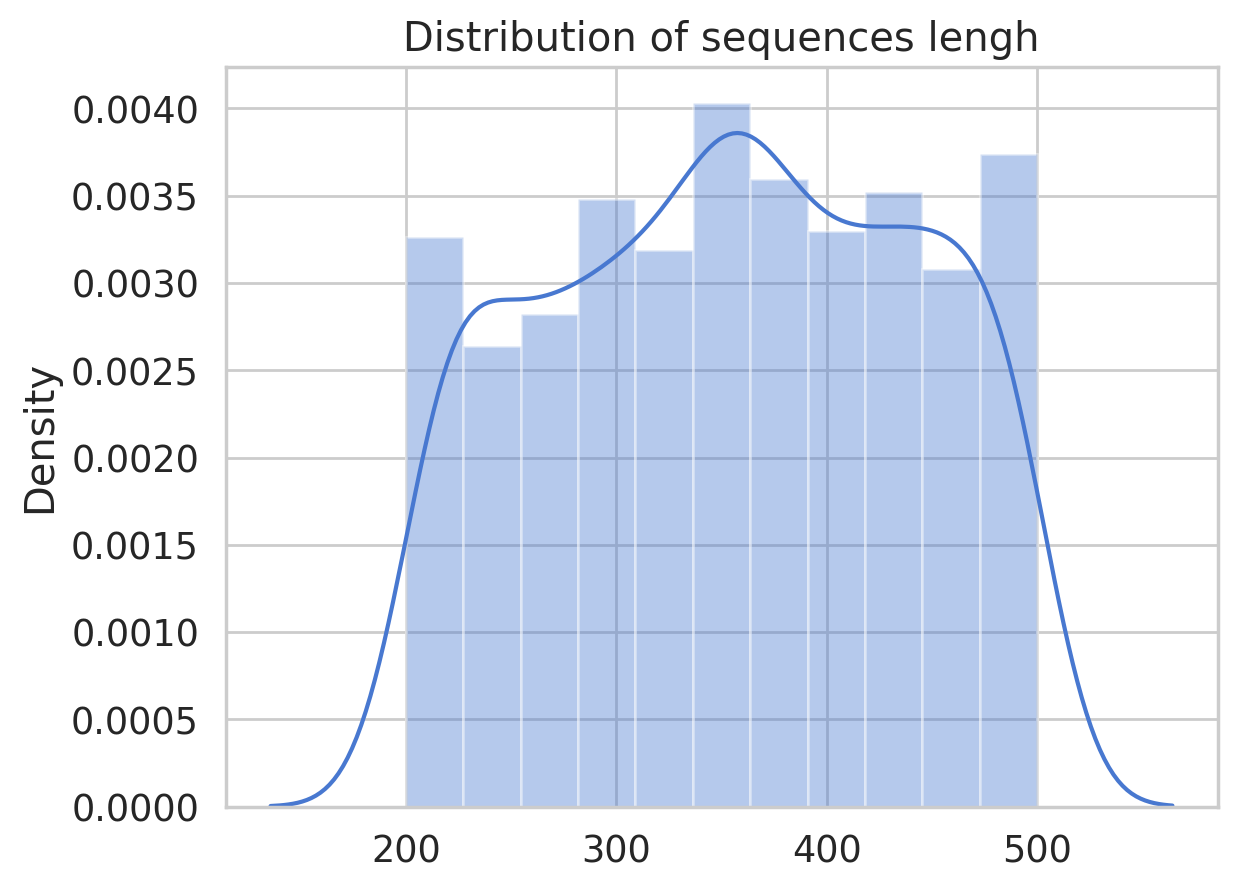

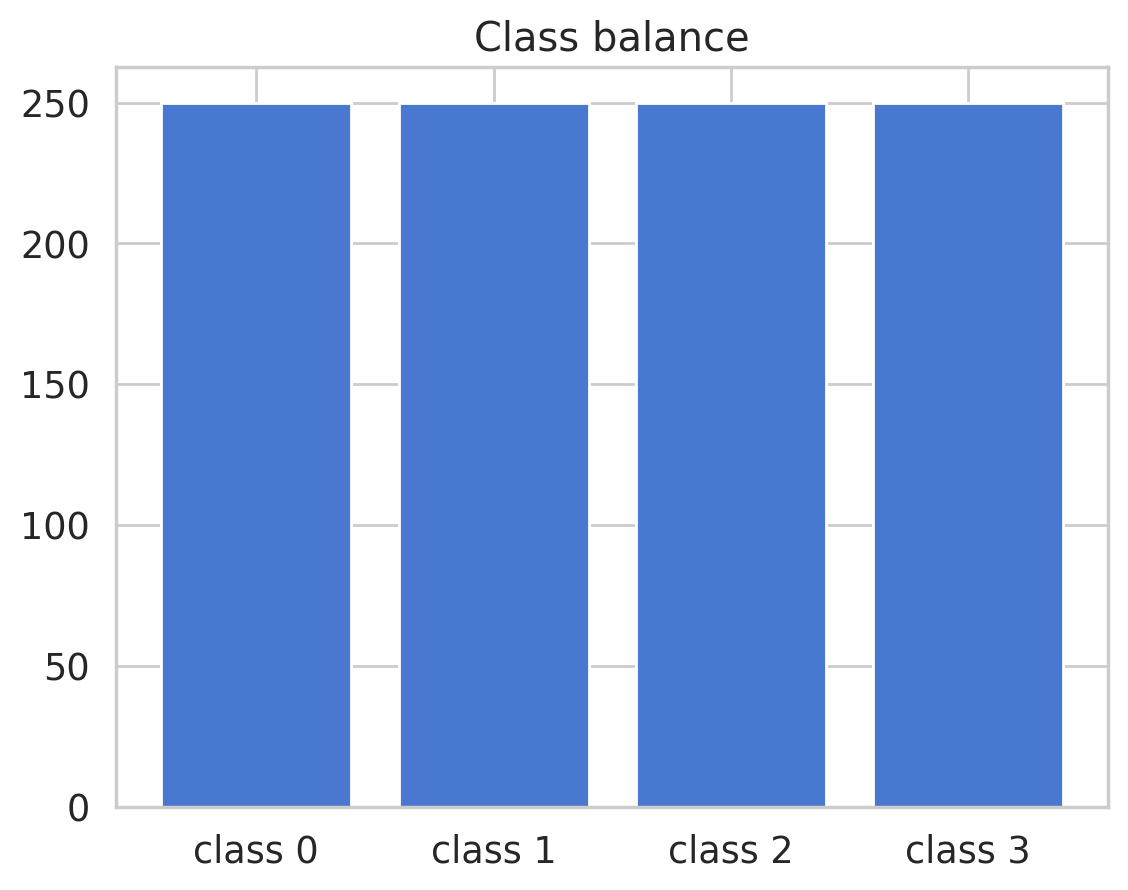

In [ ]:
statistics(sequences)
stats2(all_labels)

## Работа с трансформерами

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )

In [ ]:
# Print the original sentence.
print(' Original: ', seq_spase[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(seq_spase[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(seq_spase[0])))

 Original:  M E P E A P D S R K R P L E T P P E V V C T K R S N T G E E G E Y F L K V L I P S Y A A G S I I G K G G Q T I V Q L Q K E T G A T I K L S K S K D F Y P G T T E R V C L V Q G T A E A L N A V H S F I A E K V R E I P Q A M T K P E V V N I L Q P Q T T M N P D R A K Q A K L I V P N S T A G L I I G K G G A T V K A V M E Q S G A W V Q L S Q K P E G I N L Q E R V V T V S G E P E Q V H K A V S A I V Q K V Q E D P Q S S S C L N I S Y A N V A G P V A N S N P T G S P Y A S P A D V L P A A A A A S A A A A S G L L G P A G L A G V G A F P A A L P A F S G T D L L A I S T A L N T L A S Y G Y N T N S L S L G L N S A A A S G V L A A V A A G A N P A A A A A A N L L A S Y A G D A G A G P G A G A A P P P P P P P G A L G S F A L A A A A N G Y L G A G A G G A A G A G G A P L V A A A A A A G A A G G F L T A E K L A A E S A K E L V E I A V P E N L V G A I L G K G G K T L V E Y Q E L T G A R I Q I S K K G E F L P G T R N R R V T I T G S P A A T Q A A Q Y L I S Q R V T Y E Q G V R A S N P Q K V G 
Tok

In [ ]:
max_len = 0
for seq in seq_spase:
    input_ids = tokenizer.encode(seq, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max seq length: ', max_len)

Max seq length:  502


Функция для токенизации

In [ ]:
def tokenize_all(seq_spase, all_labels): #tokenizeall of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  for seq in seq_spase:
      encoded_dict = tokenizer.encode_plus(seq, add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 350, pad_to_max_length = True, # Я использую 350, так как образцы большей длины не влезают в GPU Colab
                          return_attention_mask = True, return_tensors = 'pt')

      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(all_labels)
  return (input_ids, attention_masks, labels)

In [ ]:
input_ids, attention_masks, labels = tokenize_all(seq_spase, all_labels)

print('Original: ', seq_spase[0])
print('Token IDs:', input_ids[0])

Original:  M E P E A P D S R K R P L E T P P E V V C T K R S N T G E E G E Y F L K V L I P S Y A A G S I I G K G G Q T I V Q L Q K E T G A T I K L S K S K D F Y P G T T E R V C L V Q G T A E A L N A V H S F I A E K V R E I P Q A M T K P E V V N I L Q P Q T T M N P D R A K Q A K L I V P N S T A G L I I G K G G A T V K A V M E Q S G A W V Q L S Q K P E G I N L Q E R V V T V S G E P E Q V H K A V S A I V Q K V Q E D P Q S S S C L N I S Y A N V A G P V A N S N P T G S P Y A S P A D V L P A A A A A S A A A A S G L L G P A G L A G V G A F P A A L P A F S G T D L L A I S T A L N T L A S Y G Y N T N S L S L G L N S A A A S G V L A A V A A G A N P A A A A A A N L L A S Y A G D A G A G P G A G A A P P P P P P P G A L G S F A L A A A A N G Y L G A G A G G A A G A G G A P L V A A A A A A G A A G G F L T A E K L A A E S A K E L V E I A V P E N L V G A I L G K G G K T L V E Y Q E L T G A R I Q I S K K G E F L P G T R N R R V T I T G S P A A T Q A A Q Y L I S Q R V T Y E Q G V R A S N P Q K V G 
Toke

Функция для разбиения на трейн, валидацию и тест

In [ ]:
from torch.utils.data import TensorDataset, random_split


def split_data(input_ids, attention_masks, labels, n_train=0.7, n_val=0.2):
  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 70-20-10 train-validation split.

  # Calculate the number of samples to include in each set.
  train_size = int(n_train * len(dataset))
  val_size = int(n_val * len(dataset))
  test_size = len(dataset) - train_size - val_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size))
  print('{:>5,} test samples'.format(test_size))
  return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = split_data(input_ids, attention_masks, labels)

  700 training samples
  200 validation samples
  100 test samples


Создаем даталодер для трейна и валидации

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_dataloader = DataLoader(train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Используем BertForSequenceClassification.
model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False)

model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 4

total_steps = len(train_dataloader) * epochs

# Создаем the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    # Takes a time in seconds and returns a string hh:mm:ss

    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


### Fine tuning

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        model.zero_grad()


        res = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))



    #Validation
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)


        with torch.no_grad():


            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')


df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.663912,0.534988,0.835,0:03:21,0:00:17
2,0.231884,0.446679,0.835,0:03:20,0:00:17
3,0.095147,0.490584,0.845,0:03:20,0:00:17


Text(0.5, 1.0, 'Training & Validation Loss')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

([<matplotlib.axis.XTick at 0x787748f67ca0>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

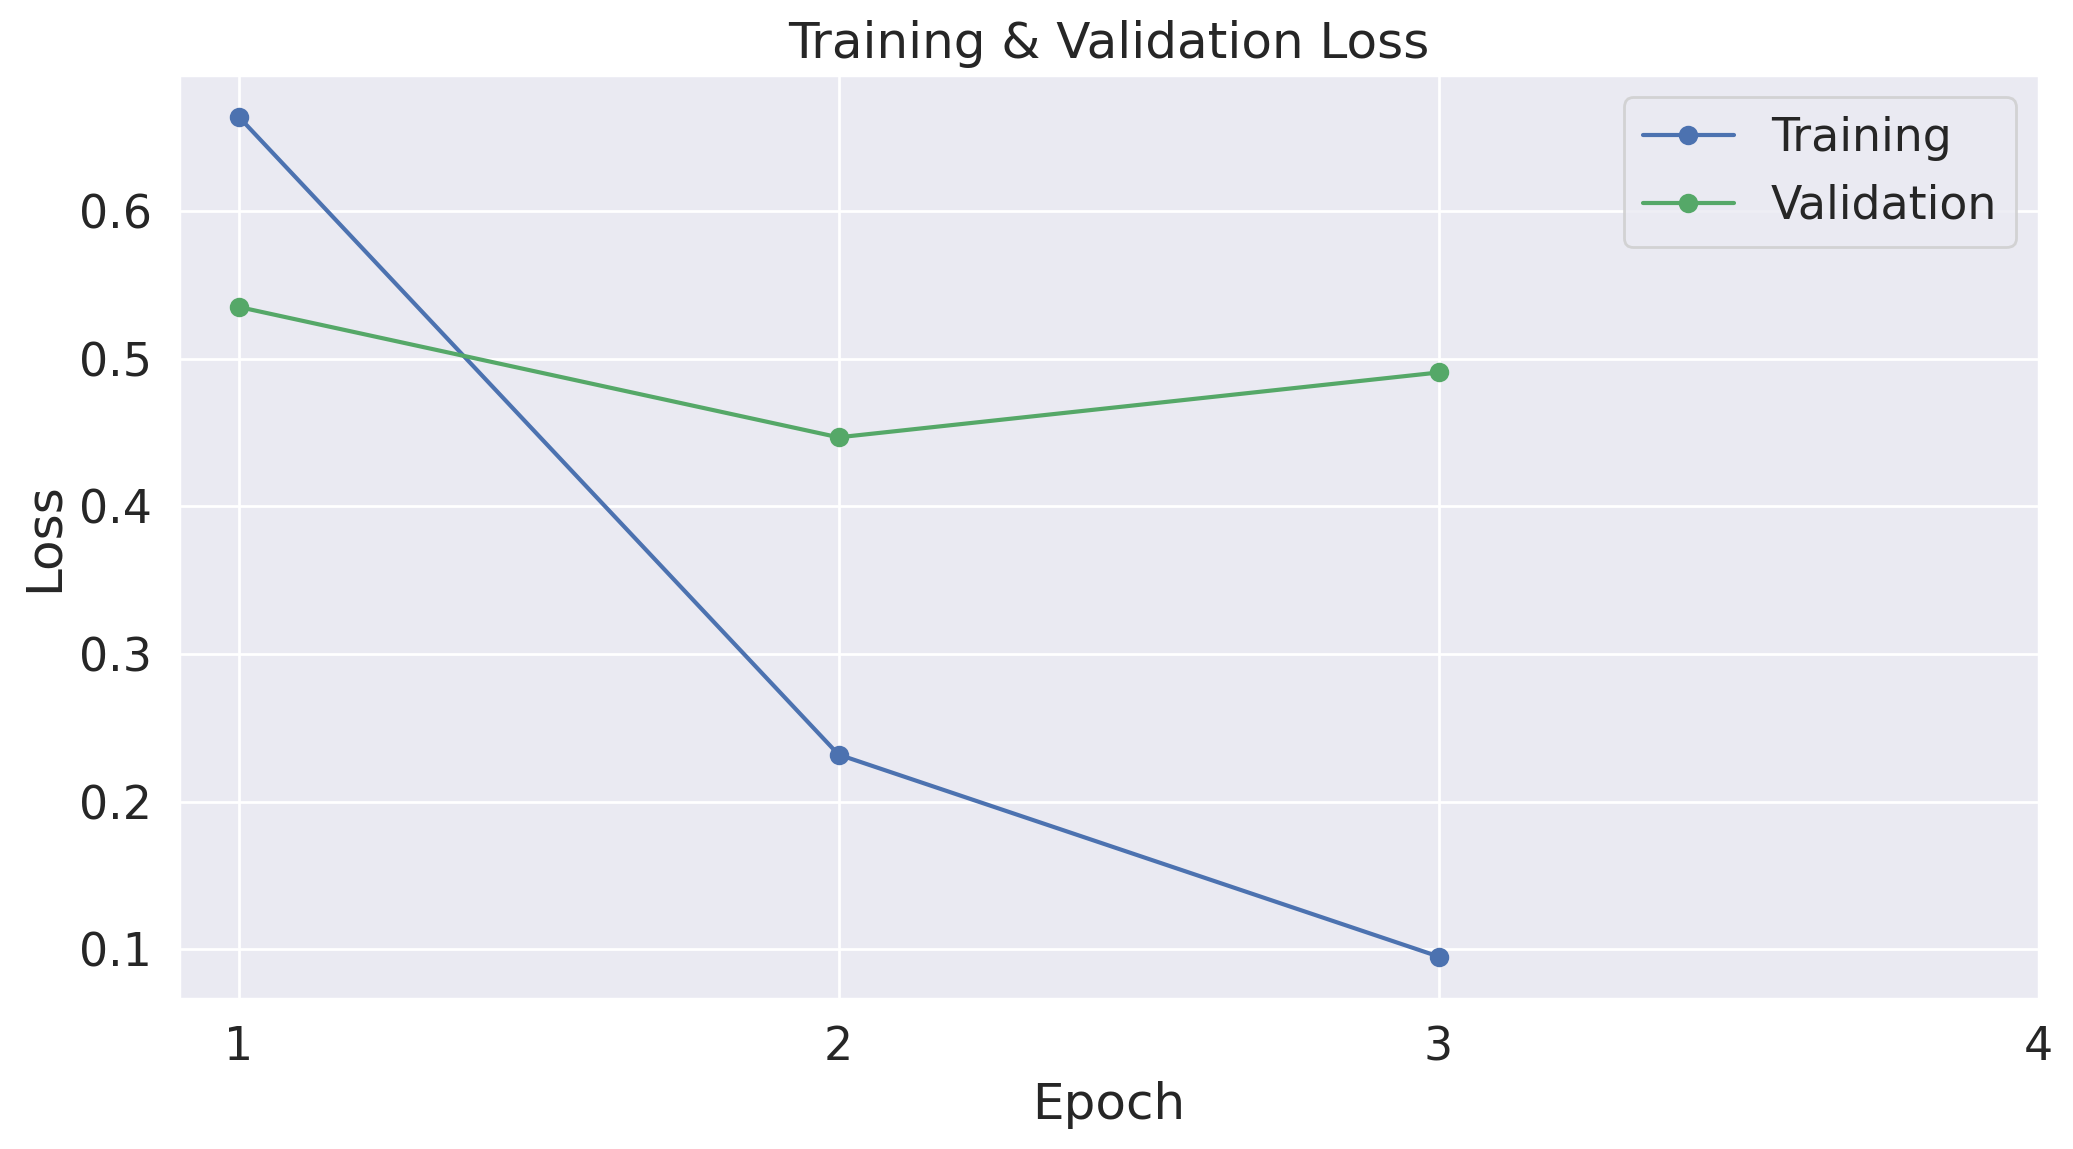

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Тестирование модели на других данных

In [ ]:
sequences_test, labels_test = preprocessing(df, n=50, reverse=False)
seq_spase_test = add_spases(sequences_test)

Labels:
nucleus 0
cytosolic 1
membrane 2
mth 3


In [ ]:
input_ids = []
attention_masks = []

for seq in seq_spase_test:
    encoded_dict = tokenizer.encode_plus(seq,
                        add_special_tokens = True,
                        max_length = 350,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

# Set the batch size.
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

    DONE.


In [ ]:
from sklearn.metrics import f1_score
res = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  score = f1_score(true_labels[i], pred_labels_i, average='micro')
  res.append(score)

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

f_sc = f1_score(flat_true_labels, flat_predictions, average='micro')

print('Total f1_score: %.3f' % f_sc)

Total f1_score: 0.800


Ура! Кажется модель работает

# А теперь проделаем все это для более большого набора данных

In [ ]:
sequences_big, all_labels_big = preprocessing(df, n=3200)
seq_spaces_big = add_spases(sequences_big)

Labels:
nucleus 0
cytosolic 1
membrane 2
mth 3


<ipython-input-52-88c2e924b9ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot([len(i) for i in sequences]).set(title = 'Distribution of sequences lengh')


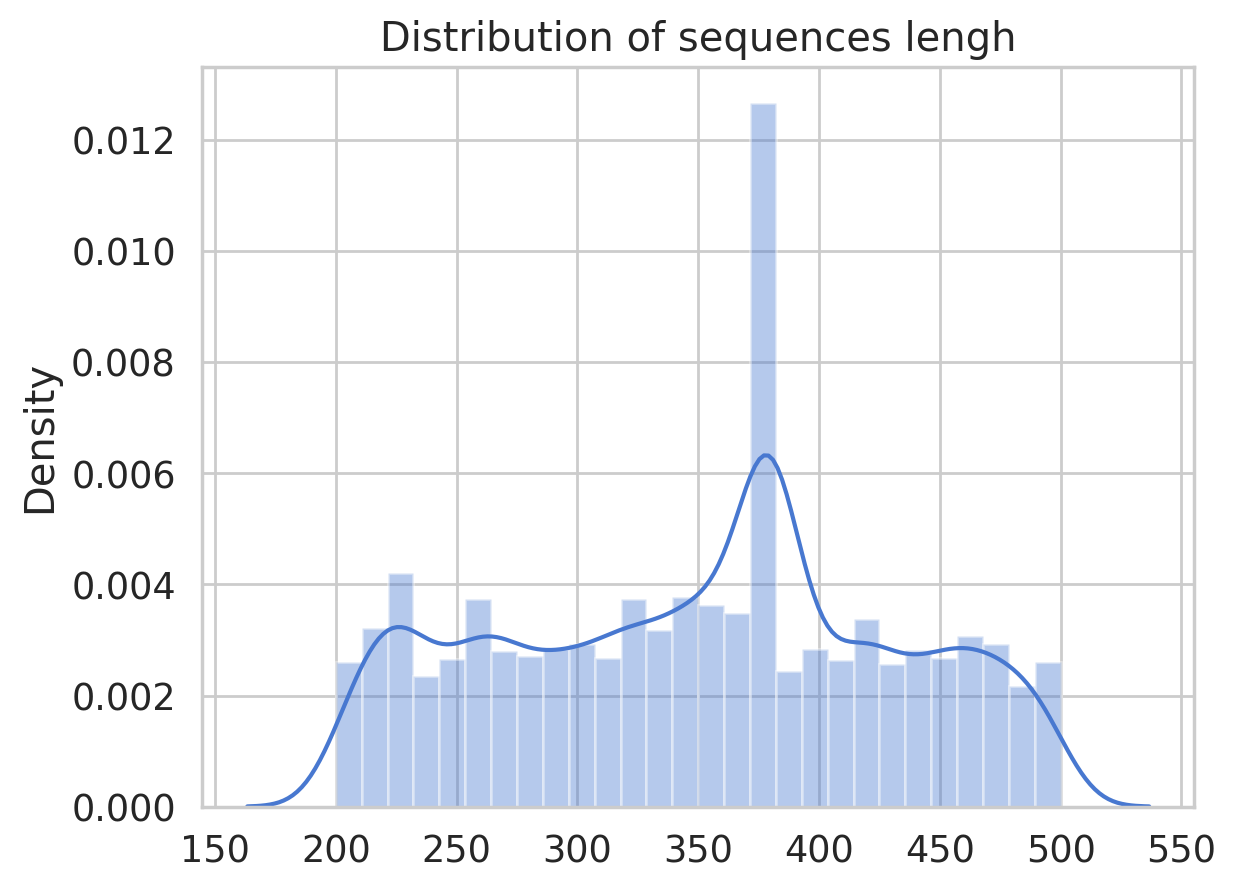

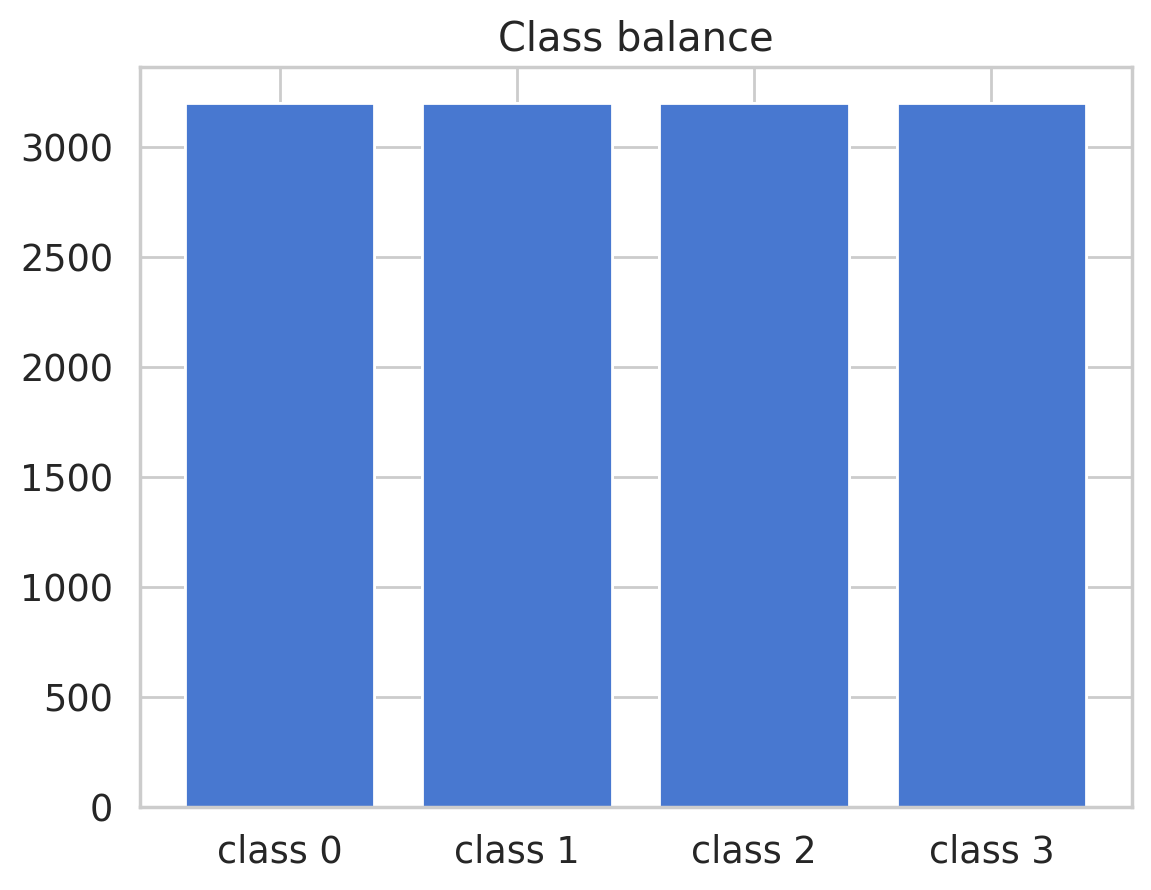

In [ ]:
statistics(sequences_big)
stats2(all_labels_big)

In [ ]:
input_ids_b, attention_masks_b, labels_b = tokenize_all(seq_spaces_big, all_labels_big)

print('Original: ', seq_spaces_big[0])
print('Token IDs:', input_ids_b[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  M E P E A P D S R K R P L E T P P E V V C T K R S N T G E E G E Y F L K V L I P S Y A A G S I I G K G G Q T I V Q L Q K E T G A T I K L S K S K D F Y P G T T E R V C L V Q G T A E A L N A V H S F I A E K V R E I P Q A M T K P E V V N I L Q P Q T T M N P D R A K Q A K L I V P N S T A G L I I G K G G A T V K A V M E Q S G A W V Q L S Q K P E G I N L Q E R V V T V S G E P E Q V H K A V S A I V Q K V Q E D P Q S S S C L N I S Y A N V A G P V A N S N P T G S P Y A S P A D V L P A A A A A S A A A A S G L L G P A G L A G V G A F P A A L P A F S G T D L L A I S T A L N T L A S Y G Y N T N S L S L G L N S A A A S G V L A A V A A G A N P A A A A A A N L L A S Y A G D A G A G P G A G A A P P P P P P P G A L G S F A L A A A A N G Y L G A G A G G A A G A G G A P L V A A A A A A G A A G G F L T A E K L A A E S A K E L V E I A V P E N L V G A I L G K G G K T L V E Y Q E L T G A R I Q I S K K G E F L P G T R N R R V T I T G S P A A T Q A A Q Y L I S Q R V T Y E Q G V R A S N P Q K V G 
Toke

In [ ]:
train_dataset_b, val_dataset_b, test_dataset_b = split_data(input_ids_b, attention_masks_b, labels_b)

8,960 training samples
2,560 validation samples
1,280 test samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_dataloader_b = DataLoader(
            train_dataset_b,
            sampler = RandomSampler(train_dataset_b),
            batch_size = batch_size)

validation_dataloader_b = DataLoader(
            val_dataset_b,
            sampler = SequentialSampler(val_dataset_b),
            batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("Rostlab/prot_bert",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader_b) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# @title Текст заголовка по умолчанию
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader_b):
      #update progress in every 500 steps
        if step % 500 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            #print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader_b), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader_b)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))




    #Validation
    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader_b:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            res = model(b_input_ids, token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader_b)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader_b)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
  
__Training...__\
Average training loss: 0.46 \
Training epcoh time: 0:36:07

__Validation...__\
*Accuracy: 0.90*\
  Validation Loss: 0.41\
  Validation took: 0:03:22

======== Epoch 2 / 4 ========
  
__Training...__\
Average training loss: 0.24 \
Training epcoh time: 0:36:08

__Validation...__\
*Accuracy: 0.96*\
  Validation Loss: 0.19\
  Validation took: 0:03:23

======== Epoch 3 / 4 ========
  
__Training...__\
Average training loss: 0.13 \
Training epcoh time: 0:36:07

__Validation...__\
*Accuracy: 0.96*\
  Validation Loss: 0.17\
  Validation took: 0:03:23


======== Epoch 4 / 4 ========
  
__Training...__\
Average training loss: 0.06 \
Training epcoh time: 0:36:06

__Validation...__\
*Accuracy: 0.97*\
  Validation Loss: 0.14\
  Validation took: 0:03:23

In [ ]:
#если снова нереобучу модель можно будет посмотреть статистику
# df_stats = pd.DataFrame(data=training_stats)
# df_stats = df_stats.set_index('epoch')

# df_stats

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# import seaborn as sns

# sns.set(style='darkgrid')

# sns.set(font_scale=1.5)
# plt.rcParams["figure.figsize"] = (12,6)


# plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# plt.title("Training & Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.xticks([1, 2, 3, 4])

# plt.show()

Сохранение дообученной модели на диск

In [ ]:
import os
output_dir = './model_save/'

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Сохранение на Google Drive.
!cp -r ./model_save/ "./drive/MyDrive/Prot_bert_clf/"

# Работа с дообученной моделью, проверка качества

In [ ]:
# Загрузим fine tuned модель с гугл диска
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/Prot_bert_clf/")

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

Тестирование модели на раннее созданном тестовом наборе

In [ ]:
batch_size = 8

# Create the DataLoader.
prediction_sampler = SequentialSampler(test_dataset_b)
prediction_dataloader = DataLoader(test_dataset_b, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

    DONE.


Оценка модели с помощью F1-score

In [ ]:
from sklearn.metrics import f1_score
res = []

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  score = f1_score(true_labels[i], pred_labels_i, average='micro')
  res.append(score)

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the score
f_sc = f1_score(flat_true_labels, flat_predictions, average='micro')

print('Total f1_score: %.4f' % f_sc)

Total f1_score: 0.9844


Вау! После дообучения на больших данных точность модели значительно выросла. Ее можно использовать для определения субклеточной локализации белка